In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [7]:
image = cv2.imread('images\selfie.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

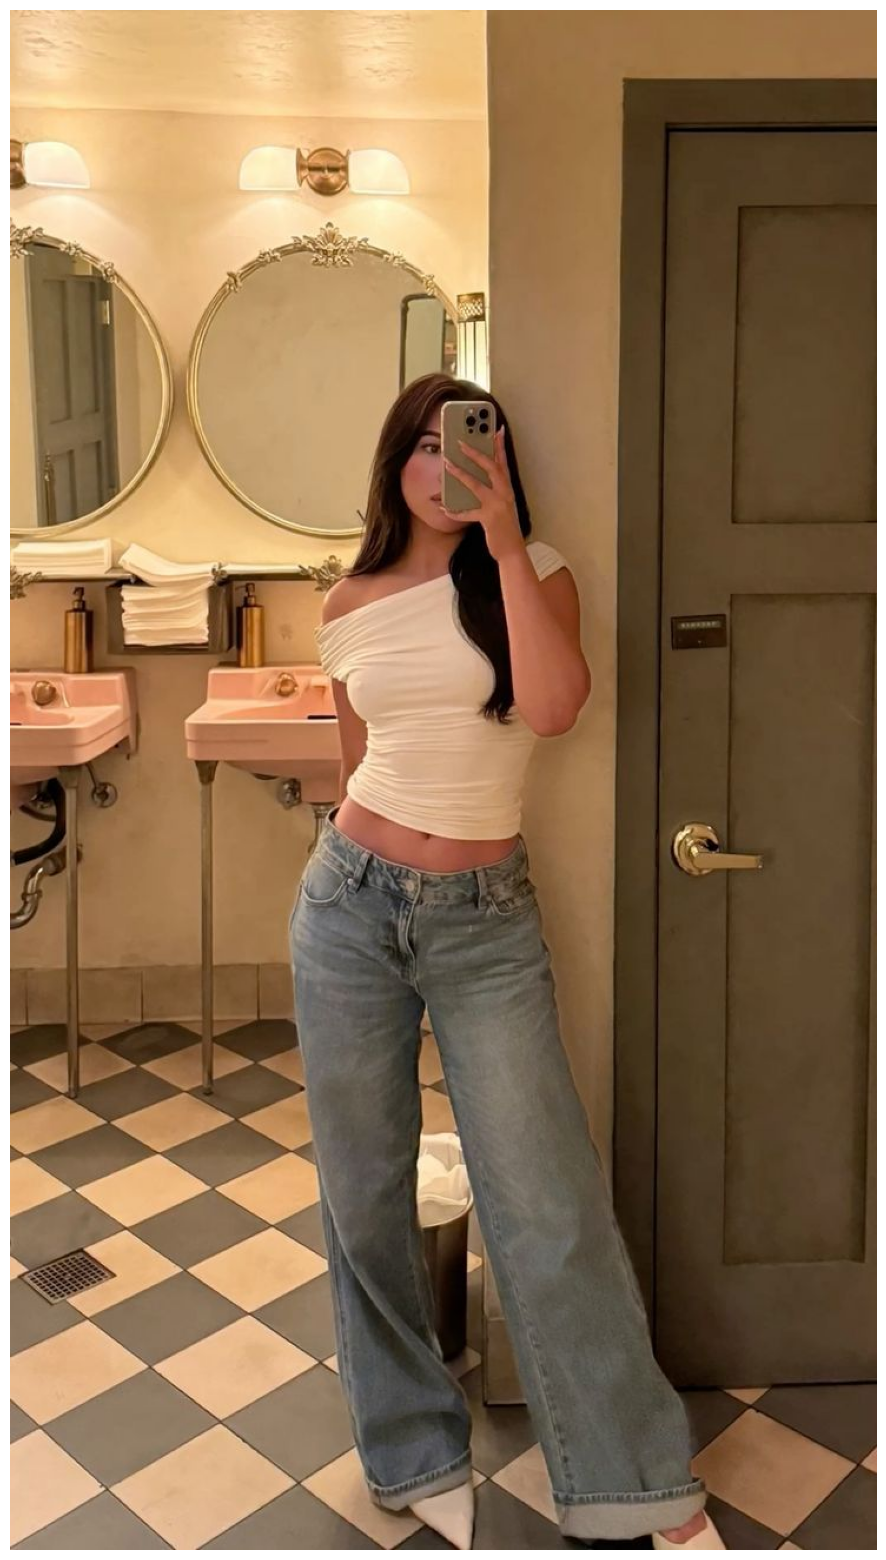

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

To generate masks, just run `generate` on an image.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [10]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    crop_n_layers=0,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

In [11]:
masks = mask_generator.generate(image)

In [12]:
len(masks)

75

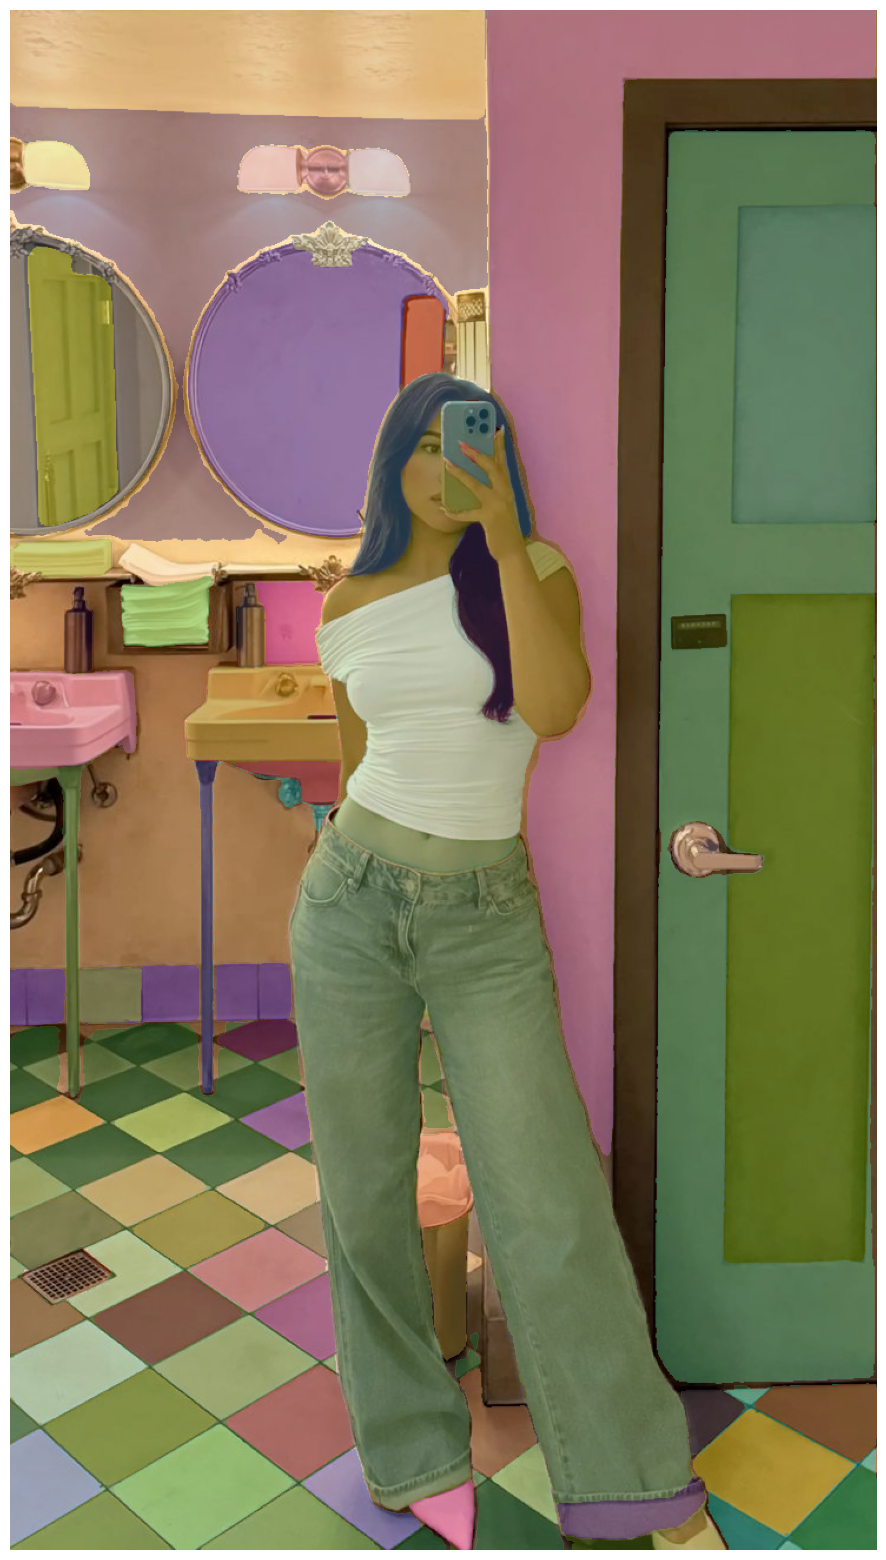

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Clip Image identifica la persona

In [14]:
import torch
import clip
from PIL import Image
import numpy as np

# Cargar modelo CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [34]:
# Definí tu prompt textual
text_prompt = "person with clothes and pants and shirt"  # Cambiá por "pants", "clothes", etc.
text_tokens = clip.tokenize([text_prompt]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

# --- Acumular máscaras relevantes ---
mask_shape = masks[0]["segmentation"].shape
combined_mask = np.zeros(mask_shape, dtype=bool)
threshold = 0.267  # Ajustá este valor según tu caso

for i, mask in enumerate(masks):
    segmentation = mask["segmentation"]

    # Aplicar la máscara sobre la imagen original
    masked_image_np = image.copy()
    masked_image_np[~segmentation] = 0

    # Preprocesar para CLIP
    masked_pil = Image.fromarray(masked_image_np)
    processed = preprocess(masked_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(processed)
        similarity = torch.cosine_similarity(image_features, text_features).item()

    print(f"Máscara {i}: score CLIP = {similarity:.4f}")

    if similarity > threshold:
        combined_mask |= segmentation

# 'image' es tu array RGB original
image_pil = Image.fromarray(image).convert("RGBA")
image_np = np.array(image_pil)

# Usar la mejor máscara seleccionada por CLIP
mask = combined_mask # Esta es la máscara booleana que seleccionaste antes

# Asegurar que la imagen tenga canal alfa
if image_np.shape[2] == 3:
    image_np = np.concatenate([image_np, 255 * np.ones((*image_np.shape[:2], 1), dtype=np.uint8)], axis=2)

# Aplicar la máscara: lo que NO está en la máscara se vuelve transparente
image_np[~mask] = [0, 0, 0, 0]

# --- CROP automático ---
# Encontrar los límites del área con máscara (bounding box)
ys, xs = np.where(mask)
if ys.size > 0 and xs.size > 0:
    top, bottom = ys.min(), ys.max()
    left, right = xs.min(), xs.max()

    # Recortar la imagen y guardar
    cropped_image_np = image_np[top:bottom+1, left:right+1]
    cropped_image = Image.fromarray(cropped_image_np)
    cropped_image.save("images/selfie_noBG.png")
    cropped_image.show()
else:
    print("⚠️ La máscara está vacía. No se puede hacer crop.")



Máscara 0: score CLIP = 0.2959
Máscara 1: score CLIP = 0.2393
Máscara 2: score CLIP = 0.2463
Máscara 3: score CLIP = 0.2463
Máscara 4: score CLIP = 0.2463
Máscara 5: score CLIP = 0.2320
Máscara 6: score CLIP = 0.2463
Máscara 7: score CLIP = 0.2463
Máscara 8: score CLIP = 0.2285
Máscara 9: score CLIP = 0.2252
Máscara 10: score CLIP = 0.2463
Máscara 11: score CLIP = 0.2463
Máscara 12: score CLIP = 0.2414
Máscara 13: score CLIP = 0.2463
Máscara 14: score CLIP = 0.2464
Máscara 15: score CLIP = 0.2463
Máscara 16: score CLIP = 0.2463
Máscara 17: score CLIP = 0.2453
Máscara 18: score CLIP = 0.2237
Máscara 19: score CLIP = 0.2462
Máscara 20: score CLIP = 0.2463
Máscara 21: score CLIP = 0.2463
Máscara 22: score CLIP = 0.2463
Máscara 23: score CLIP = 0.2259
Máscara 24: score CLIP = 0.2291
Máscara 25: score CLIP = 0.2335
Máscara 26: score CLIP = 0.2463
Máscara 27: score CLIP = 0.2463
Máscara 28: score CLIP = 0.2463
Máscara 29: score CLIP = 0.2244
Máscara 30: score CLIP = 0.2463
Máscara 31: score 

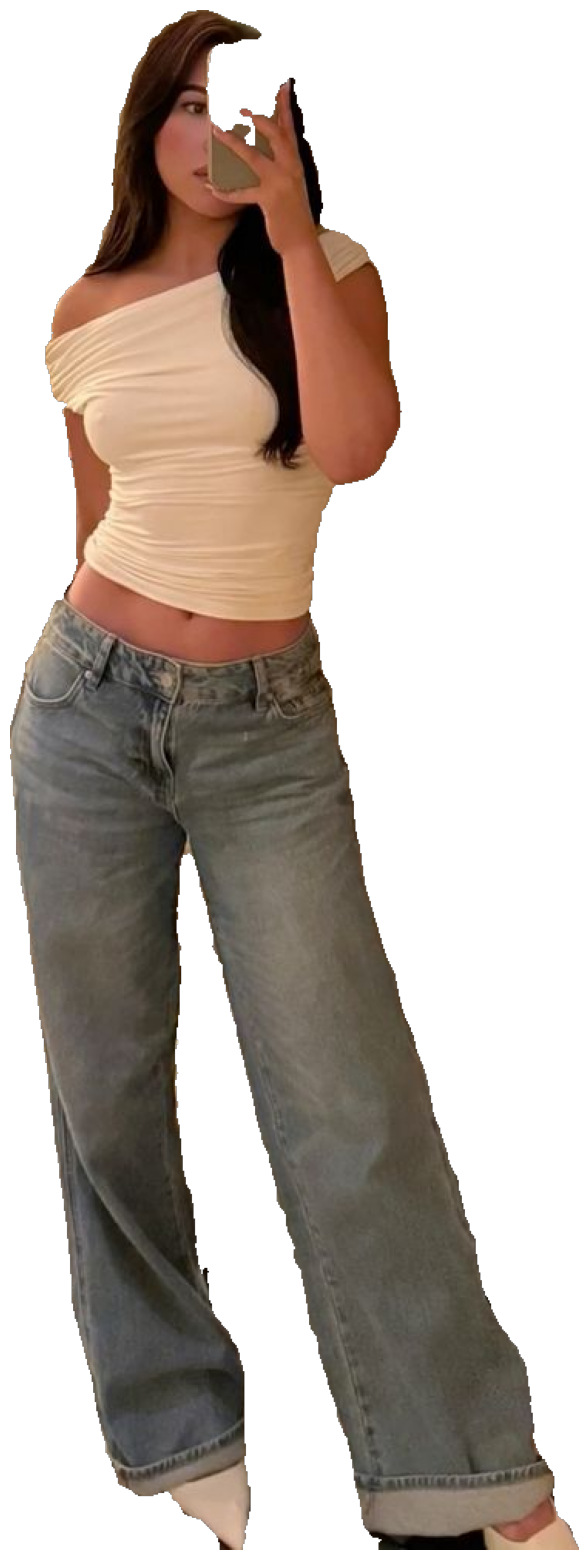

In [35]:
#Mostrar imagen con fondo eliminado
output_image = Image.open("images/selfie_noBG.png")
plt.figure(figsize=(20,20))
plt.imshow(output_image)
plt.axis('off')
plt.show()

## Ahora SAM para los prendas

In [36]:
image2 = cv2.imread('images/selfie_noBG.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [37]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    crop_n_layers=0,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

In [38]:
masks2 = mask_generator_2.generate(image2)

In [39]:
len(masks2)

11

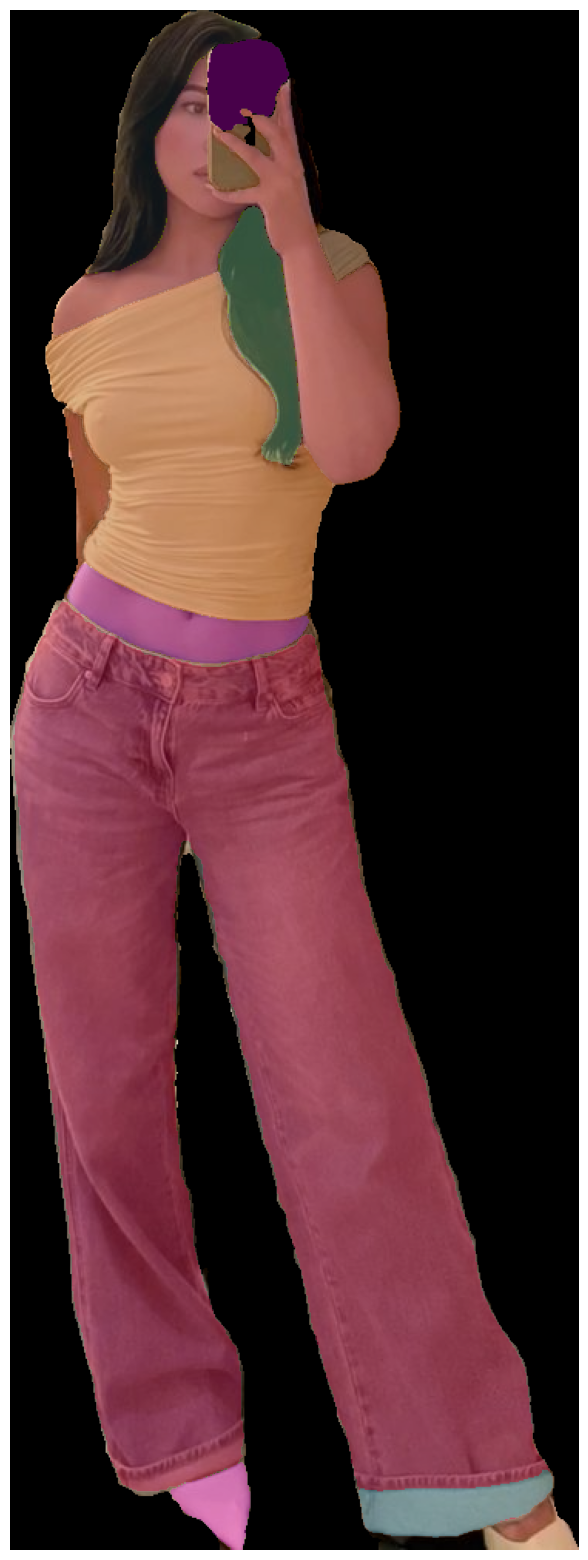

In [40]:
plt.figure(figsize=(20,20))
plt.imshow(image2)
show_anns(masks2)
plt.axis('off')
plt.show()

## Clip

In [41]:
import torch
import clip
from PIL import Image
import numpy as np

# Cargar modelo CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [50]:
# Definí tu prompt textual
text_prompt = "only shirt"  # Si se pone only y prenda funciona
text_tokens = clip.tokenize([text_prompt]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

# Evaluar cada máscara
best_score = -1
best_mask = None
best_crop = None

for i, mask in enumerate(masks2):
    segmentation = mask["segmentation"]  # Boolean numpy array

    # Aplicar máscara sobre la imagen original
    image_np = np.array(image2)
    masked_image_np = image_np.copy()
    masked_image_np[~segmentation] = 0  # Poner en negro lo que no está en la máscara

    # Convertir a PIL, procesar y pasar por CLIP
    masked_pil = Image.fromarray(masked_image_np)
    processed = preprocess(masked_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(processed)
        similarity = torch.cosine_similarity(image_features, text_features).item()

    print(f"Máscara {i}: score CLIP = {similarity:.4f}")
    
    if similarity > best_score:
        best_score = similarity
        best_mask = segmentation
        best_crop = masked_pil


Máscara 0: score CLIP = 0.2153
Máscara 1: score CLIP = 0.2153
Máscara 2: score CLIP = 0.2153
Máscara 3: score CLIP = 0.2297
Máscara 4: score CLIP = 0.2488
Máscara 5: score CLIP = 0.2229
Máscara 6: score CLIP = 0.2153
Máscara 7: score CLIP = 0.2153
Máscara 8: score CLIP = 0.2153
Máscara 9: score CLIP = 0.2153
Máscara 10: score CLIP = 0.2153


In [48]:
print(f"Seleccionada la máscara con mejor match: score {best_score:.4f}")
best_crop.save("images/pants_crop.png")
best_crop.show()

Seleccionada la máscara con mejor match: score 0.2827


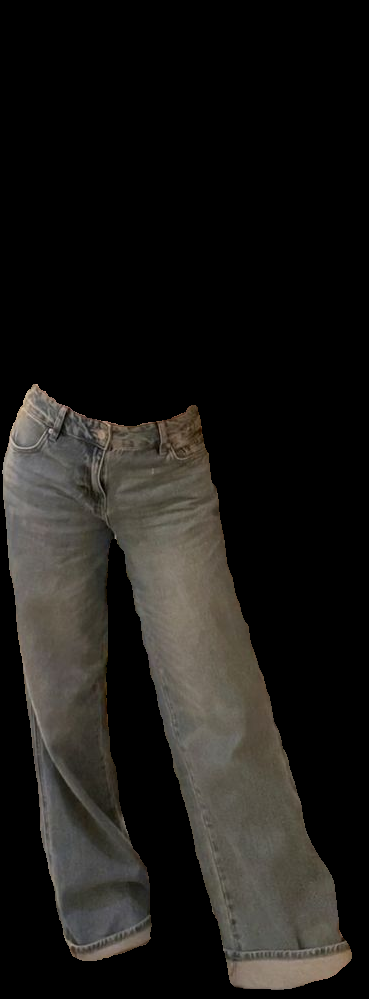

In [49]:
#Visualizo crops
img = Image.open("images/pants_crop.png")
display(img)

Seleccionada la máscara con mejor match: score 0.2488


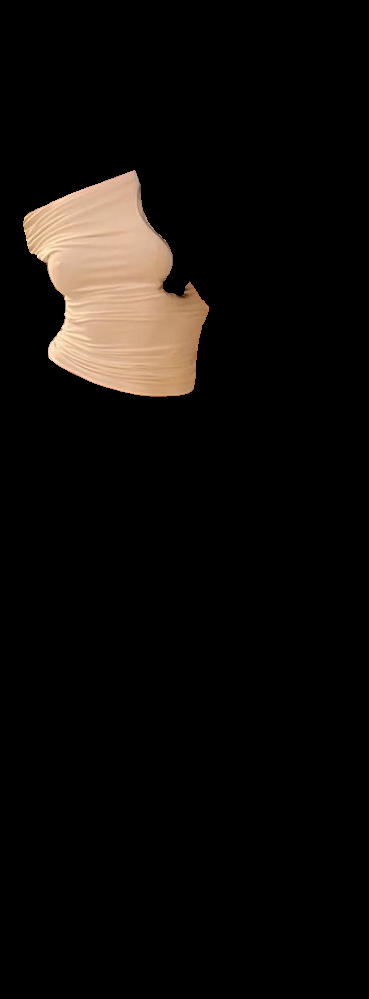

In [51]:
print(f"Seleccionada la máscara con mejor match: score {best_score:.4f}")
best_crop.save("images/shirt_crop.png")
best_crop.show()

img = Image.open("images/shirt_crop.png")
display(img)